# DepthUnet With DenseNet Encoder

Install the required libraries

In [1]:
!pip install torchgeometry
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 111 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


Download the dataset

In [2]:
!gdown 1OwK-wAmygNZ5sxF8T63mTG6EvLdRi0lV
!unzip -q nyu_data.zip

Downloading...
From: https://drive.google.com/uc?id=1OwK-wAmygNZ5sxF8T63mTG6EvLdRi0lV
To: /content/nyu_data.zip
100% 4.40G/4.40G [00:21<00:00, 205MB/s]


Import the required modules

In [3]:
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
from PIL import Image
from io import BytesIO
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torchgeometry.losses import SSIM
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.nn as nn

Define the Dataset

In [4]:
class DepthDataset(Dataset):
    def __init__(self, file_path, samples=1000):
        super(DepthDataset, self).__init__()
        self.data_list = pd.read_csv(file_path, header=None).sample(samples)

    def __getitem__(self, idx):

        # load the image and the depth matp
        image_path = self.data_list.iloc[idx, 0]
        depth_path = self.data_list.iloc[idx, 1]

        image = Image.open(image_path)
        mask = Image.open(depth_path)

        # resize the image
        image = TF.resize(image, 480)
        mask = TF.resize(mask, 480)

        H, W = image.size

        if H % 32 != 0:
          H = H-H%32
        if W % 32 != 0:
          W = W-W%32

        image = TF.resize(image, (H, W))
        mask = TF.resize(mask, (H, W))

        # Convert the image to tensors
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)

        return image, mask

    def __len__(self):
        return len(self.data_list)

Load the datasets in the loaders

In [5]:
train_set = DepthDataset("/content/data/nyu2_train.csv", samples=100)
val_set = DepthDataset('/content/data/nyu2_train.csv', samples=100)

train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=True)

Define the model

In [6]:
import torch
import torch.nn as nn
from torchvision import models

class DepthUnet(nn.Module):
  def __init__(self):
    super(DepthUnet, self).__init__()

    # Define the encoder layers
    self.dense_net = models.densenet121(pretrained=True)
    self.freeze_pretrained_model(False)

    # Define the decoder layers
    self.dec1 = nn.Conv2d(1024+1024, 512, 3, padding=1)
    self.d_bn1 = nn.BatchNorm2d(512)

    self.dec2 = nn.Conv2d(512+512, 256, 5, padding=1)
    self.d_bn2 = nn.BatchNorm2d(256)
    
    self.dec3 = nn.Conv2d(256+256, 128, 5, padding=1)
    self.d_bn3 = nn.BatchNorm2d(128)
    
    self.dec4 = nn.Conv2d(64+128, 16, 7, padding=1)
    self.d_bn4 = nn.BatchNorm2d(16)

    self.dec5 = nn.Conv2d(16+3, 1, 9, padding=1)

  def forward(self, images):
    # Encode the input image
    features = [images[:, 0:3, :, :]]
    for _, layer in self.dense_net.features._modules.items():
        features.append(layer(features[-1]))

    enc6 = features[11]
    enc5 = features[9]
    enc4 = features[7]
    enc3 = features[5]
    enc2 = features[3]
    enc1 = features[0]

    # Decode the input image
    _, _, H, W = enc5.shape
    up1 = nn.functional.interpolate(enc6, size=(H, W), mode='bilinear')
    dec1 = F.relu(self.d_bn1(self.dec1(torch.cat((up1, enc5), dim=1))))

    _, _, H, W = enc4.shape
    up2 = nn.functional.interpolate(dec1, size=(H, W), mode='bilinear')
    dec2 = F.relu(self.d_bn2(self.dec2(torch.cat((up2, enc4), dim=1))))

    _, _, H, W = enc3.shape
    up3 = nn.functional.interpolate(dec2, size=(H, W), mode='bilinear')
    dec3 = F.relu(self.d_bn3(self.dec3(torch.cat((up3, enc3), dim=1))))

    _, _, H, W = enc2.shape
    up4 = nn.functional.interpolate(dec3, size=(H, W), mode='bilinear')
    dec4 = F.relu(self.dec4(torch.cat((up4, enc2), dim=1)))

    _, _, H, W = enc1.shape
    up5 = nn.functional.interpolate(dec4, size=(H, W), mode='bilinear')
    dec5 = torch.sigmoid(self.dec5(torch.cat((images, up5), dim=1)))

    # Return the final decoded image
    return nn.functional.interpolate(dec5, size=(H, W), mode='bilinear')

  def freeze_pretrained_model(self, freeze: bool):
    for param in self.dense_net.features.parameters():
      param.requires_grad = not freeze

Loss:

In [7]:
from torch.nn import MSELoss, L1Loss, HuberLoss
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Model will train on {device}")
model = DepthUnet()

Model will train on cuda


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [9]:
criterion1 = L1Loss()
criterion2 = HuberLoss()
criterion3 = MSELoss()

In [11]:
def scale_invariant_loss(y_true, y_pred):
    y_true_sum = torch.sum(y_true)
    y_pred_sum = torch.sum(y_pred)

    y_true_squared_sum = torch.sum(y_true ** 2)
    y_pred_squared_sum = torch.sum(y_pred ** 2)

    num = y_true_sum * y_pred_sum
    den = y_true_squared_sum * y_pred_squared_sum

    return num / den

In [12]:
def dice_loss_with_sigmoid(sigmoid, targets, smooth=1.0):
	"""
  Works
	sigmoid: (torch.float32)  shape (N, 1, H, W)
	targets: (torch.float32) shape (N, H, W), value {0,1}
	"""
	outputs = torch.squeeze(sigmoid, dim=1)

	inter = outputs * targets
	dice = 1 - ((2*inter.sum(dim=(1,2)) + smooth) / (outputs.sum(dim=(1,2))+targets.sum(dim=(1,2)) + smooth))
	dice = dice.mean()
	return dice

In [13]:
l1_criterion = L1Loss()

In [14]:
optimizer = SGD(model.parameters(), lr=1e-3)
# optimizer = Adam(model.parameters(), lr=0.01, momentum=0.99)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=0, factor=0.9)

In [15]:
model = model.to(device)

Model Training

In [18]:
import time, sys
import matplotlib.pyplot as plt
batch_size = 1
from torch.utils.tensorboard import SummaryWriter
from collections import defaultdict
writer = SummaryWriter()

def train(num_epochs: int, batch_size: int, metrics:list, names:list):
    start_time = time.time()

    training_steps = len(train_set) // batch_size
    val_steps = len(val_set) // batch_size

    training_losses = {}
    val_losses = {}

    best_avg_val_loss = sys.maxsize

    for epoch in range(num_epochs):
        model.train()

        total_training_losses = defaultdict(int)
        total_val_losses = defaultdict(int)
        total_training_loss=0
        total_val_loss=0


        for i, (images, labels) in enumerate(train_loader, 0):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            preds = model(images)
            # for i, metric in enumerate(metrics):
            #   total_training_losses[i]+=metric(preds, labels)

            net_loss = criterion3(preds, labels)

            total_training_loss += net_loss.item()

            net_loss.backward()
            optimizer.step()

            scheduler.step(net_loss.item())
                
        with torch.no_grad():
            model.eval()

            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                # for i, metric in enumerate(metrics):
                #   total_val_losses[i]+=metric(preds, labels)
                preds = model(images)
                net_loss = criterion3(preds, labels)
                total_val_loss += net_loss.item()
       
        # for i, metric in enumerate(metrics):
        #     writer.add_scalar(f'Training/{names[i]}', total_training_losses[i], epoch+1)
        #     writer.add_scalar(f'Validation/{names[i]}', total_val_losses[i], epoch+1)

        avg_training_loss = total_training_loss 
        avg_val_loss = total_val_loss 

            
        print(f"{epoch+1} | Train Loss: {avg_training_loss:.5f} | Val Loss: {avg_val_loss:.5f}")

        torch.cuda.empty_cache()

        if avg_val_loss < best_avg_val_loss:
            torch.save(model.state_dict(), "best_model.pth")
            best_avg_val_loss = avg_val_loss

    end_time = time.time()
    print(f"Total training time: {(end_time - start_time):.2f}s")

    return training_losses, testing_losses

In [19]:
train(3, 1, 
          metrics=[L1Loss(), HuberLoss(), MSELoss(), dice_loss_with_sigmoid, scale_invariant_loss], 
          names=['L1 Loss', 'Huber Loss', 'MSE Loss', 'Dice Loss', 'SI Loss'])

1 | Train Loss: 6.49292 | Val Loss: 6.42461
2 | Train Loss: 6.33451 | Val Loss: 6.41607
3 | Train Loss: 6.33353 | Val Loss: 6.42751
Total training time: 140.68s


In [20]:
# %load_ext tensorboard
# %tensorboard --logdir runs

Prediction

In [21]:
input_image, output_image = next(iter(train_loader))

In [22]:
model.to('cpu')
model_output = model(input_image)

In [23]:
model_output = model_output[0][0].detach().numpy()

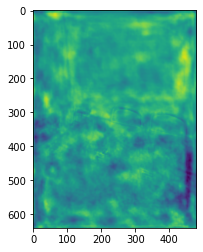

In [24]:
import matplotlib.pyplot as plt

plt.imshow(model_output)
plt.show()

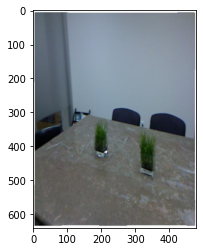

In [25]:
plt.imshow(input_image[0].permute(1, 2, 0))

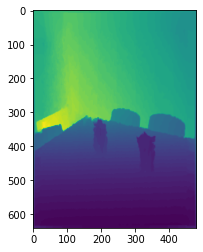

In [26]:
plt.imshow(output_image[0][0])

In [ ]:
from google.colab import files
files.download('best_model.pth')

In [ ]:
best_model = DepthUnet()

best_model.load_state_dict(torch.load("best_model.pth"))

count = 0
for input, label in train_loader:
  output = model(input)
  plt.imshow(input[0].permute(1, 2, 0))
  plt.show()
  plt.imshow(output[0][0].detach().numpy())
  plt.show()
  plt.imshow(label[0][0])
  plt.show()
  count+=1
  if count==5:
    break